In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from datetime import datetime

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import get_weather_data


In [11]:
weatherData = get_weather_data.WeatherData("2022-01-01", str(datetime.today()), dallas_flag="Dallas")

df = weatherData.build_obs_df()

df = df.fillna(0)

Probably need to clean this data up a bit

working from this example
https://keras.io/examples/timeseries/timeseries_weather_forecasting/


End of data
End of data


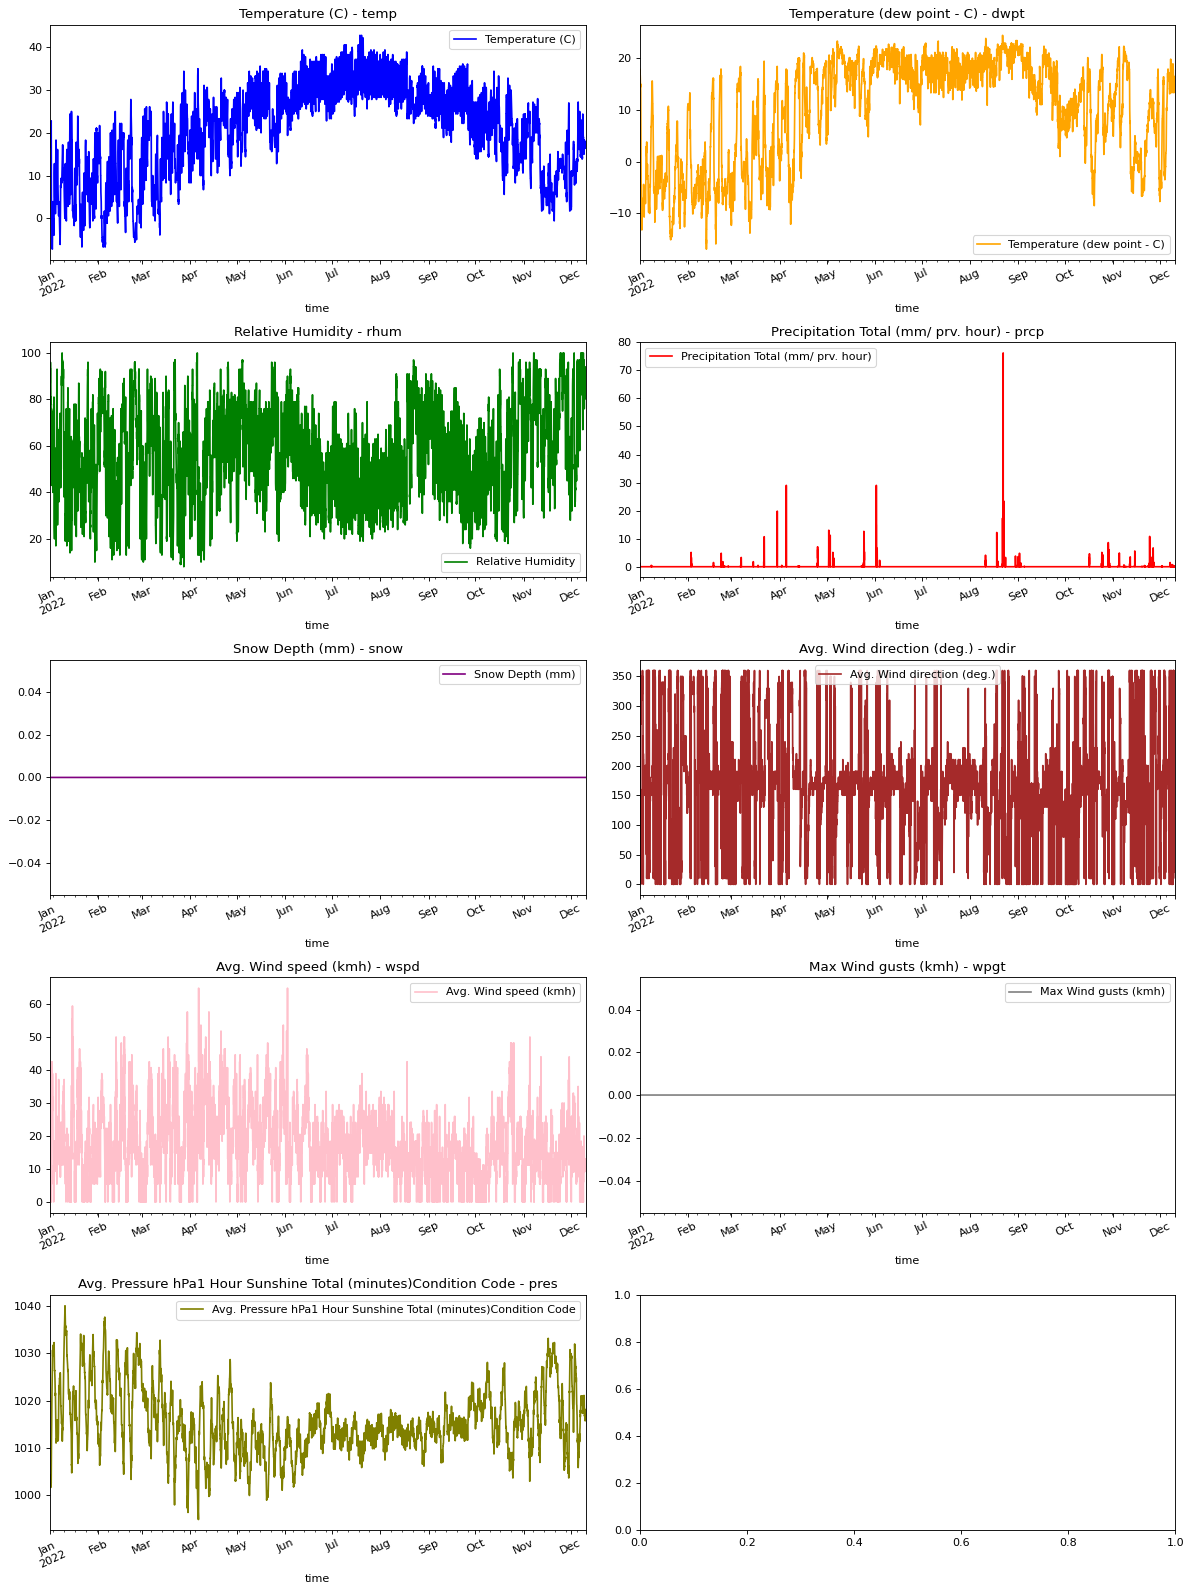

In [12]:
titles = [
    "Temperature (C)",
    "Temperature (dew point - C)",
    "Relative Humidity",
    "Precipitation Total (mm/ prv. hour)",
    "Snow Depth (mm)",
    "Avg. Wind direction (deg.)",
    "Avg. Wind speed (kmh)",
    "Max Wind gusts (kmh)",
    "Avg. Pressure hPa"
    "1 Hour Sunshine Total (minutes)"
    "Condition Code",
]

feature_keys = [
    "temp",
    "dwpt",
    "rhum",
    "prcp",
    "snow",
    "wdir",
    "wspd",
    "wpgt",
    "pres",
    "tsun",
    "coco",
]

colors = [
    "blue",
    "orange",
    "green",
    "red",
    "purple",
    "brown",
    "pink",
    "gray",
    "olive",
    "cyan",
]

date_time_key = "time"

def show_raw_visualization(data):
    time_data = data[date_time_key]
    fig, axes = plt.subplots(
        nrows=5, ncols=2, figsize=(15, 20), dpi=80, facecolor="w", edgecolor="k"
    )
    for i in range(len(feature_keys)):
        try:
            key = feature_keys[i]
            c = colors[i % (len(colors))]
            t_data = data[key]
            t_data.index = time_data
            t_data.head()
            ax = t_data.plot(
                ax=axes[i // 2, i % 2],
                color=c,
                title="{} - {}".format(titles[i], key),
                rot=25,
            )
            ax.legend([titles[i]])
        except:
            print("End of data")
    plt.tight_layout()


show_raw_visualization(df)

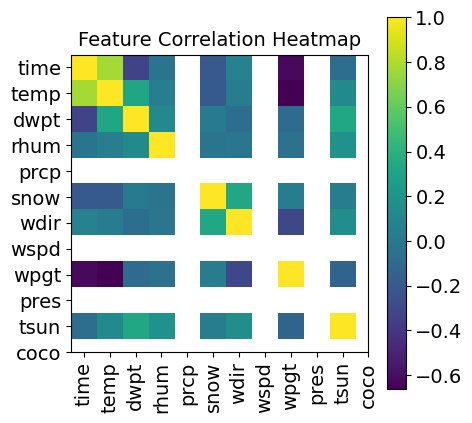

In [13]:
def show_heatmap(data):
    plt.matshow(data.corr())
    plt.xticks(range(data.shape[1]), data.columns, fontsize=14, rotation=90)
    plt.gca().xaxis.tick_bottom()
    plt.yticks(range(data.shape[1]), data.columns, fontsize=14)

    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.title("Feature Correlation Heatmap", fontsize=14)
    plt.show()


show_heatmap(df)


In [14]:
#Define Models

#define models for later use

def rnn_model(X_train, y_train, X_test, sc):
    rnn = keras.Sequential()
    rnn.add(keras.layers.SimpleRNN(128, return_sequences=True))
    rnn.add(keras.layers.SimpleRNN(128, return_sequences=True))
    rnn.add(keras.layers.SimpleRNN(256, return_sequences=True))
    rnn.add(keras.layers.SimpleRNN(32))
    rnn.add(keras.layers.Dense(units = 1))

    rnn.compile(optimizer='rmsprop', loss='mean_squared_error')
    rnn.fit(X_train, y_train, epochs=15, batch_size=32)
    predicted_rnn = rnn.predict(X_test)
    #un-normalize
    predicted_rnn = sc.inverse_transform(predicted_rnn)
    return predicted_rnn


def lstm_model(X_train, y_train, X_test, sc):
    lstm = keras.Sequential()
    lstm.add(keras.layers.LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
    lstm.add(keras.layers.Dropout(rate = 0.2))
    lstm.add(keras.layers.LSTM(units = 50, return_sequences = True))
    lstm.add(keras.layers.Dropout(rate = 0.2))
    lstm.add(keras.layers.LSTM(units = 50, return_sequences = True))
    lstm.add(keras.layers.Dropout(rate = 0.2))
    lstm.add(keras.layers.LSTM(units = 50, return_sequences = False))
    lstm.add(keras.layers.Dropout(rate = 0.2))
    lstm.add(keras.layers.Dense(units = 1))

    lstm.compile(optimizer = 'adam', loss = 'mean_squared_error')
    lstm.fit(x = X_train, y = y_train, batch_size = 32, epochs = 15)
    predicted_lstm = lstm.predict(X_test)
    #un-normalize
    predicted_lstm = sc.inverse_transform(predicted_lstm)
    return predicted_lstm


def gru_model(X_train, y_train, X_test, sc):
    gru = keras.Sequential()
    gru.add(keras.layers.GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    gru.add(keras.layers.GRU(units=50, return_sequences=True))
    gru.add(keras.layers.GRU(units=50, return_sequences=True))
    gru.add(keras.layers.GRU(units=50, return_sequences=False, activation='tanh'))
    gru.add(keras.layers.Dense(units=1))

    history = gru.compile(optimizer='rmsprop', loss='mean_squared_error')
    gru.fit(X_train, y_train, batch_size = 32, epochs = 15)
    predicted_gru = gru.predict(X_test)
    #un-normalize
    predicted_gru = sc.inverse_transform(predicted_gru)
    return predicted_gru

In [15]:
#create a function that can be called with a label as a parameter to generate predictions based on 3 kinds of models
#this can be used to determine the best model for each label

def predict_am(label):
    #get just the column we're working with
    
    data = df[label].values.reshape(-1,1)

    #drop unneeded data
    #data = df.iloc[:, 0: 1].values

    # create standardization parameters
    sc = MinMaxScaler(feature_range = (0, 1)) 
    
    # apply standardization to the dataset
    data = sc.fit_transform(data) 
    
    #create blank lists for X and y values
    X = []
    y  = []

    
    #arrange data for use case
    #use the previous 72 time steps to predict the next step
    for i in range(72, len(data)): # in the range from the 73rd value to the end
        X.append(data[i-60: i, 0]) # load the previous 72 values into x
        y.append(data[i, 0]) # load the current value into y

    #split training and test data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .10, random_state = 42)

    X_train = np.array(X_train)
    X_test = np.array(X_test)
    y_train = np.array(y_train)
    y_test = np.array(y_test)

    
    #reshape data to fit model inputs
    X_train = np.reshape(X_train, newshape = (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, newshape = (X_test.shape[0], X_test.shape[1], 1))
    #y_train = np.reshape(y_train, newshape = (y_train.shape[0], y_train.shape[1], 1))
    #y_test = np.reshape(y_test, newshape = (y_test.shape[0], y_test.shape[1], 1))

    

    predicted_rnn = rnn_model(X_train, y_train, X_test, sc)
    predicted_lstm = lstm_model(X_train, y_train, X_test, sc)
    predicted_gru = gru_model(X_train, y_train, X_test, sc)

    #un-normalize y test values
    org = sc.inverse_transform(y_test.reshape(-1, 1))

    #plot the predictions and the original data in the same line graph
    plt.plot(org, label = label)
    plt.plot(predicted_rnn, label = 'Recurrent Neural Network')
    plt.plot(predicted_lstm, label = 'Long Short Term Memory Network')
    plt.plot(predicted_gru, label = 'Gated Recurrent Unit')
    plt.title(label + " prediction")
    plt.xlabel('Time')
    plt.ylabel(label)
    plt.legend()
    plt.show()

    #create a blank dict to load values into
    model_accuracy = {}

    #get MSE of each model and load into dict
    rmse_rnn = np.sqrt(mean_squared_error(org, predicted_rnn))
    model_accuracy.update({"RNN": rmse_rnn})

    rmse_lstm = np.sqrt(mean_squared_error(org, predicted_lstm))
    model_accuracy.update({"LSTM": rmse_lstm})

    rmse_gru = np.sqrt(mean_squared_error(org, predicted_gru))
    model_accuracy.update({"GRU": rmse_gru})

    #show the values
    print ('Test RMSE - RNN: %.3f' % rmse_rnn)
    print ('Test RMSE - LSTM: %.3f' % rmse_lstm)
    print ('Test RMSE - GRU: %.3f' % rmse_gru)

    #convert the dict into 2 lists
    model_type = list(model_accuracy.keys())
    model_acc = list(model_accuracy.values())

    #plot the lists
    plt.bar(range(len(model_accuracy)), model_acc, tick_label=model_type)
    #scale the plot
    plt.ylim(1, 2)
    plt.ylabel("MSE - Lower is better")
    #rotate the x-axis labels for readability
    plt.xticks(rotation = 90)
    plt.show()

    return min(model_accuracy)


Epoch 1/15
230/230 [==============================] - 17s 70ms/step - loss: 0.3790
Epoch 2/15
230/230 [==============================] - 17s 74ms/step - loss: 0.3005
Epoch 3/15
230/230 [==============================] - 18s 78ms/step - loss: 0.2141
Epoch 4/15
230/230 [==============================] - 18s 78ms/step - loss: 0.0663
Epoch 5/15
230/230 [==============================] - 18s 78ms/step - loss: 0.0439
Epoch 6/15
230/230 [==============================] - 18s 78ms/step - loss: 0.0458
Epoch 7/15
230/230 [==============================] - 18s 78ms/step - loss: 0.0436
Epoch 8/15
230/230 [==============================] - 18s 78ms/step - loss: 0.0543
Epoch 9/15
230/230 [==============================] - 18s 79ms/step - loss: 0.0238
Epoch 10/15
230/230 [==============================] - 17s 73ms/step - loss: 0.0114
Epoch 11/15
230/230 [==============================] - 17s 72ms/step - loss: 0.0099
Epoch 12/15
230/230 [==============================] - 17s 72ms/step - loss: 0.0061
E

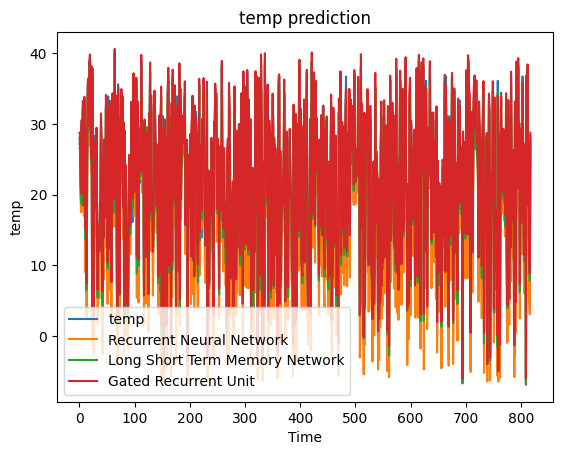

Test RMSE - RNN: 3.234
Test RMSE - LSTM: 1.280
Test RMSE - GRU: 1.433


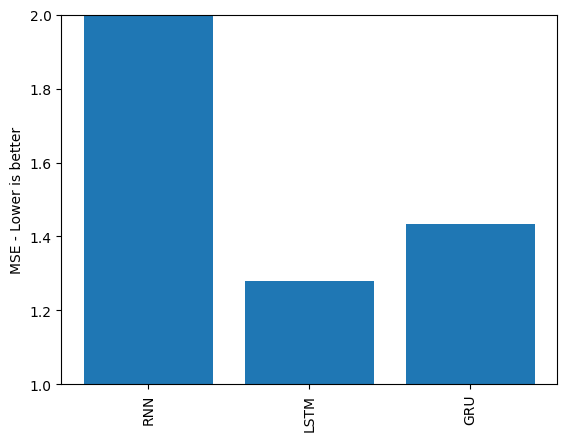

Epoch 1/15
230/230 [==============================] - 22s 91ms/step - loss: 0.2279
Epoch 2/15
230/230 [==============================] - 20s 88ms/step - loss: 0.0552
Epoch 3/15
230/230 [==============================] - 20s 89ms/step - loss: 0.0568
Epoch 4/15
230/230 [==============================] - 20s 89ms/step - loss: 0.0560
Epoch 5/15
230/230 [==============================] - 20s 89ms/step - loss: 0.0570
Epoch 6/15
230/230 [==============================] - 20s 89ms/step - loss: 0.0541
Epoch 7/15
230/230 [==============================] - 20s 88ms/step - loss: 0.0652
Epoch 8/15
230/230 [==============================] - 20s 89ms/step - loss: 0.0201
Epoch 9/15
230/230 [==============================] - 21s 89ms/step - loss: 0.0082
Epoch 10/15
230/230 [==============================] - 20s 89ms/step - loss: 0.0051
Epoch 11/15
230/230 [==============================] - 20s 89ms/step - loss: 0.0045
Epoch 12/15
230/230 [==============================] - 20s 89ms/step - loss: 0.0035
E

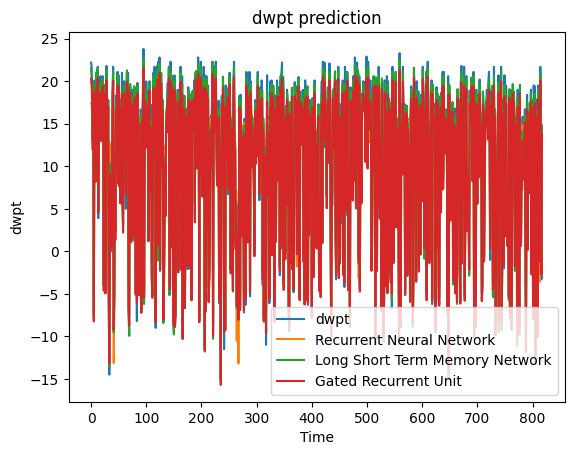

Test RMSE - RNN: 2.189
Test RMSE - LSTM: 0.984
Test RMSE - GRU: 1.340


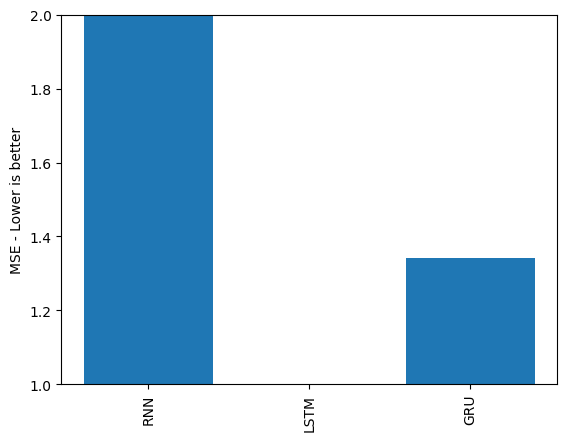

Epoch 1/15
230/230 [==============================] - 22s 90ms/step - loss: 0.1439
Epoch 2/15
230/230 [==============================] - 21s 90ms/step - loss: 0.0605
Epoch 3/15
230/230 [==============================] - 22s 95ms/step - loss: 0.0517
Epoch 4/15
230/230 [==============================] - 22s 96ms/step - loss: 0.0328
Epoch 5/15
230/230 [==============================] - 22s 96ms/step - loss: 0.0160
Epoch 6/15
230/230 [==============================] - 22s 96ms/step - loss: 0.0094
Epoch 7/15
230/230 [==============================] - 22s 96ms/step - loss: 0.0076
Epoch 8/15
230/230 [==============================] - 22s 96ms/step - loss: 0.0069
Epoch 9/15
230/230 [==============================] - 22s 96ms/step - loss: 0.0064
Epoch 10/15
230/230 [==============================] - 22s 96ms/step - loss: 0.0058
Epoch 11/15
230/230 [==============================] - 22s 96ms/step - loss: 0.0053
Epoch 12/15
230/230 [==============================] - 22s 96ms/step - loss: 0.0051
E

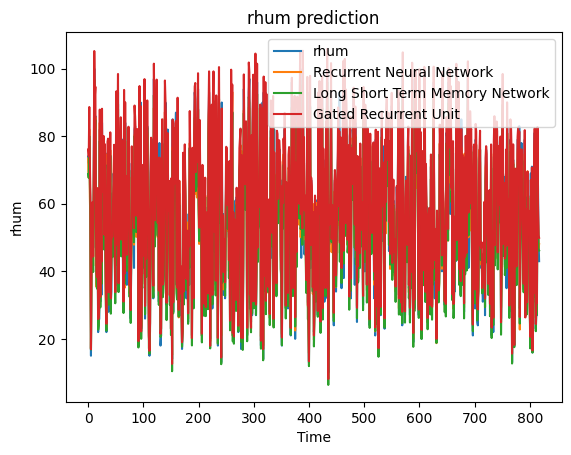

Test RMSE - RNN: 4.920
Test RMSE - LSTM: 4.746
Test RMSE - GRU: 5.889


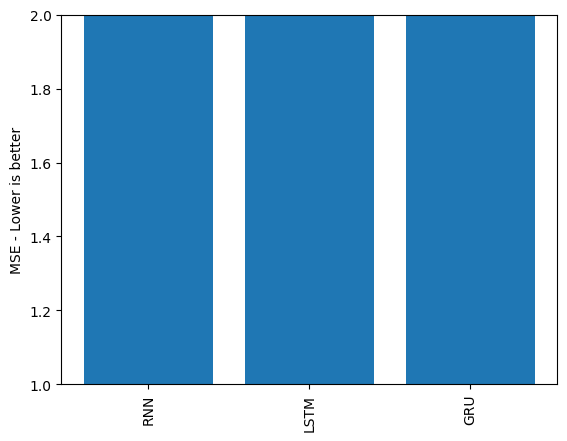

Epoch 1/15
230/230 [==============================] - 19s 78ms/step - loss: 0.0457
Epoch 2/15
230/230 [==============================] - 18s 77ms/step - loss: 5.8131e-04
Epoch 3/15
230/230 [==============================] - 18s 77ms/step - loss: 5.7513e-04
Epoch 4/15
230/230 [==============================] - 18s 77ms/step - loss: 5.5752e-04
Epoch 5/15
230/230 [==============================] - 18s 77ms/step - loss: 5.5723e-04
Epoch 6/15
230/230 [==============================] - 18s 77ms/step - loss: 5.7066e-04
Epoch 7/15
230/230 [==============================] - 18s 77ms/step - loss: 5.7166e-04
Epoch 8/15
230/230 [==============================] - 18s 77ms/step - loss: 5.8094e-04
Epoch 9/15
230/230 [==============================] - 18s 77ms/step - loss: 5.7645e-04
Epoch 10/15
230/230 [==============================] - 18s 77ms/step - loss: 5.6387e-04
Epoch 11/15
230/230 [==============================] - 18s 77ms/step - loss: 5.7972e-04
Epoch 12/15
230/230 [========================

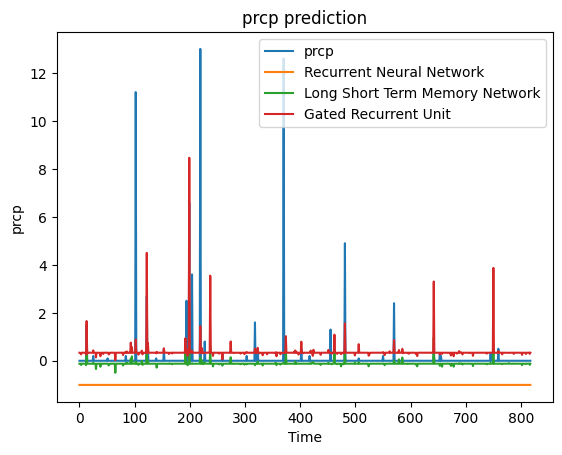

Test RMSE - RNN: 1.369
Test RMSE - LSTM: 0.833
Test RMSE - GRU: 0.824


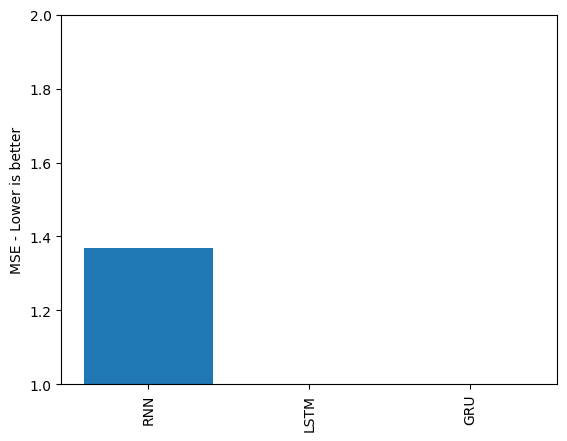

Epoch 1/15
230/230 [==============================] - 16s 62ms/step - loss: 0.2438
Epoch 2/15
230/230 [==============================] - 14s 62ms/step - loss: 0.1762
Epoch 3/15
230/230 [==============================] - 14s 62ms/step - loss: 0.1044
Epoch 4/15
230/230 [==============================] - 14s 61ms/step - loss: 0.0761
Epoch 5/15
230/230 [==============================] - 14s 61ms/step - loss: 0.0834
Epoch 6/15
230/230 [==============================] - 14s 61ms/step - loss: 0.0722
Epoch 7/15
230/230 [==============================] - 14s 61ms/step - loss: 0.0707
Epoch 8/15
230/230 [==============================] - 14s 61ms/step - loss: 0.0707
Epoch 9/15
230/230 [==============================] - 14s 61ms/step - loss: 0.0706
Epoch 10/15
230/230 [==============================] - 14s 61ms/step - loss: 0.0708
Epoch 11/15
230/230 [==============================] - 14s 61ms/step - loss: 0.0710
Epoch 12/15
230/230 [==============================] - 14s 61ms/step - loss: 0.0708
E

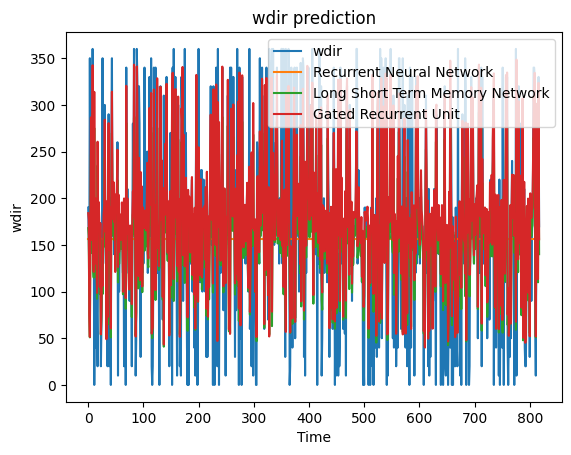

Test RMSE - RNN: 95.284
Test RMSE - LSTM: 72.988
Test RMSE - GRU: 73.773


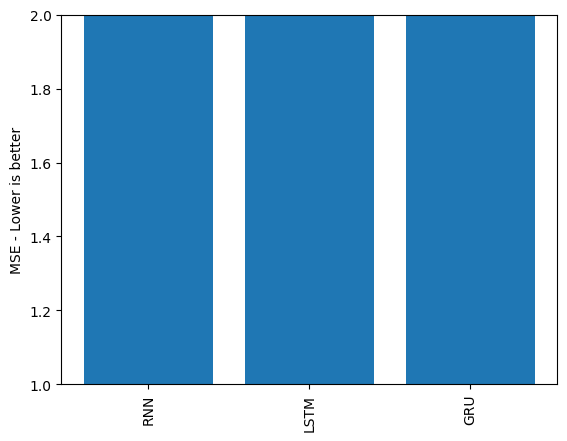

Epoch 1/15
230/230 [==============================] - 23s 97ms/step - loss: 0.1033
Epoch 2/15
230/230 [==============================] - 22s 97ms/step - loss: 0.0852
Epoch 3/15
230/230 [==============================] - 22s 97ms/step - loss: 0.0439
Epoch 4/15
230/230 [==============================] - 22s 97ms/step - loss: 0.0340
Epoch 5/15
230/230 [==============================] - 22s 97ms/step - loss: 0.0284
Epoch 6/15
230/230 [==============================] - 22s 97ms/step - loss: 0.0307
Epoch 7/15
230/230 [==============================] - 22s 97ms/step - loss: 0.0333
Epoch 8/15
230/230 [==============================] - 22s 97ms/step - loss: 0.0324
Epoch 9/15
230/230 [==============================] - 22s 97ms/step - loss: 0.0264
Epoch 10/15
230/230 [==============================] - 22s 97ms/step - loss: 0.0237
Epoch 11/15
230/230 [==============================] - 22s 97ms/step - loss: 0.0291
Epoch 12/15
230/230 [==============================] - 23s 98ms/step - loss: 0.0261
E

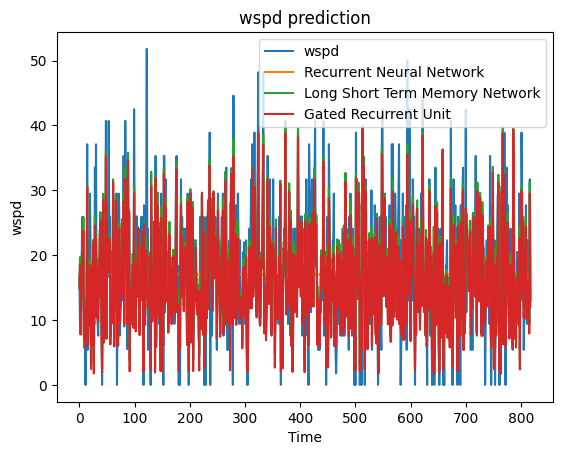

Test RMSE - RNN: 9.382
Test RMSE - LSTM: 4.969
Test RMSE - GRU: 5.233


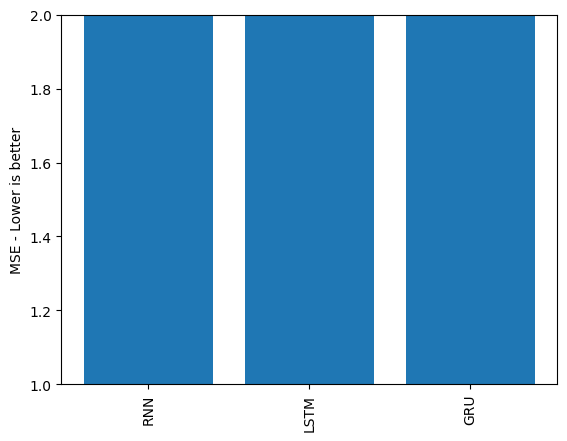

Epoch 1/15
230/230 [==============================] - 24s 100ms/step - loss: 0.1003
Epoch 2/15
230/230 [==============================] - 23s 99ms/step - loss: 0.0242
Epoch 3/15
230/230 [==============================] - 23s 98ms/step - loss: 0.1281
Epoch 4/15
230/230 [==============================] - 23s 98ms/step - loss: 0.0557
Epoch 5/15
230/230 [==============================] - 23s 98ms/step - loss: 0.0436
Epoch 6/15
230/230 [==============================] - 23s 98ms/step - loss: 0.0516
Epoch 7/15
230/230 [==============================] - 23s 98ms/step - loss: 0.0262
Epoch 8/15
230/230 [==============================] - 23s 98ms/step - loss: 0.0416
Epoch 9/15
230/230 [==============================] - 23s 98ms/step - loss: 0.0245
Epoch 10/15
230/230 [==============================] - 23s 99ms/step - loss: 0.0437
Epoch 11/15
230/230 [==============================] - 23s 100ms/step - loss: 0.0411
Epoch 12/15
230/230 [==============================] - 23s 100ms/step - loss: 0.026

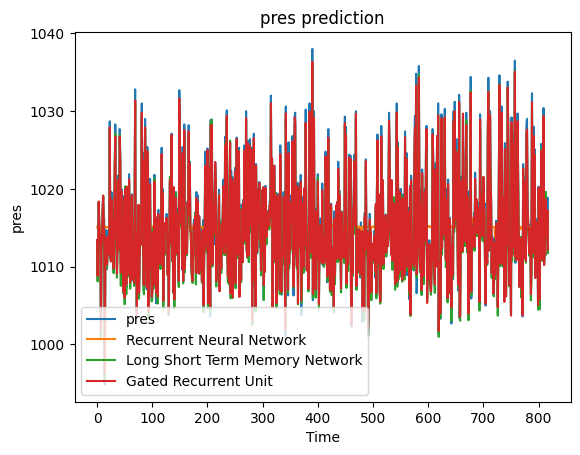

Test RMSE - RNN: 6.665
Test RMSE - LSTM: 1.045
Test RMSE - GRU: 0.688


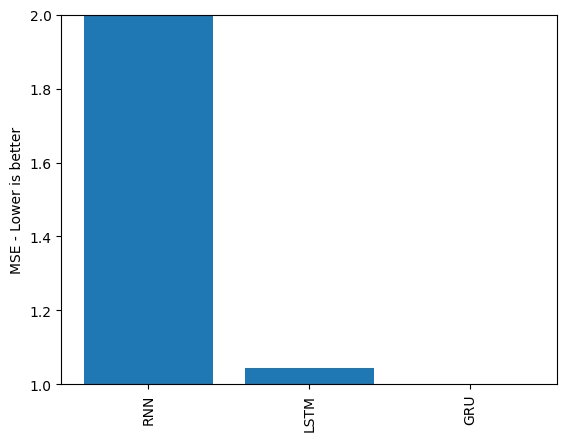

In [16]:
#predict_am(label = "temp")

#create dictionary to load columns and their best prediction model
bestPredictor = {}

#select columns to analyze
columns = ["temp", "dwpt", "rhum", "prcp", "wdir", "wspd", "pres"]

#analyze selected columns and add results to dictionary
for column in columns:
    columnpm = predict_am(label = column)
    bestPredictor.update({column : columnpm})